# Preprocessing

by `Mainak Jas` (mainakjas@gmail.com)

Notebook link: https://tinyrul.com/y5a3yfy6

We will be covering

* [Quality assurance with MNE report](#Quality-assurance-with-MNE-report)
* [Autoreject](Autoreject-and-marking-artifacts)
* [SSP](#Signal-Space-Projection-(SSP))
* [ICA](#ICA)

In [1]:
%matplotlib inline

# Quality assurance with MNE report

Let's say we want to analyze 100 subjects.

How do we do quality assurancy in a scalable manner?

## MNE report

In [2]:
from mne.report import Report

A report contains:
    * Figures
    * Images
    * Custom HTML
    * Sliders

First, let us generate some figures for the report.

In [3]:
import mne
from mne.datasets import sample

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


Now let's pretend this data came from 3 different subjects

In [4]:
raw1 = raw.copy().crop(0, 20)
raw2 = raw.copy().crop(20, 40)
raw3 = raw.copy().crop(40, 60)

raw1.save(data_path + '/MEG/sample/sub-01_raw.fif', overwrite=True)
raw2.save(data_path + '/MEG/sample/sub-02_raw.fif', overwrite=True)
raw3.save(data_path + '/MEG/sample/sub-03_raw.fif', overwrite=True)

Overwriting existing file.
Writing /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sub-01_raw.fif
Closing /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sub-01_raw.fif [done]
Overwriting existing file.
Writing /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sub-02_raw.fif
Closing /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sub-02_raw.fif [done]
Overwriting existing file.
Writing /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sub-03_raw.fif
Closing /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sub-03_raw.fif [done]


Now, we can have a function to go from raw to evoked

In [5]:
event_id = {'Auditory/Left': 3, 'Auditory/Right': 4}

def raw_to_evoked(raw_fname, tmin=-0.1, tmax=0.5):
    
    raw = mne.io.read_raw_fif(data_path + '/MEG/sample/' + raw_fname, preload=True)
    fig1 = raw.plot(show=False);
    raw.filter(0, 40.)
    
    events = mne.find_events(raw, stim_channel='STI 014')
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax)
    fig2 = epochs.plot(show=False);
    
    evoked_l = epochs['Left'].average();
    fig3 = evoked_l.plot_topomap(show=False)
    fig4 = evoked_l.plot(show=False);
    
    return [fig1, fig2, fig3, fig4]

Now, we can get all the figure handles:

In [6]:
%%capture
figs = raw_to_evoked('sub-01_raw.fif')

Now comes the actual report

In [8]:
rep = Report()

Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css


In [9]:
captions = ['Raw', 'Epochs', 'Topomap', 'Butterfly']
rep.add_figs_to_section(figs, captions=captions)
rep.save('report_raw_to_evoked.html', overwrite=True)

Saving report to location /home/mainak/Dropbox/mne_workshop_nih/Day 2/report_raw_to_evoked.html
Rendering : Table of Contents
custom
 ... Raw
 ... Epochs
 ... Topomap
 ... Butterfly


'/home/mainak/Dropbox/mne_workshop_nih/Day 2/report_raw_to_evoked.html'

The report can be found [here](report_raw_to_evoked.html)

We can go even more fancy. Let's try to process all the three subjects.

In [10]:
%%capture
rep = Report()
for idx, r in enumerate(['sub-01_raw.fif', 'sub-02_raw.fif', 'sub-03_raw.fif']):
    figs = raw_to_evoked(r)
    rep.add_figs_to_section(figs, captions=captions, section='Subject %02d' % idx)
rep.save('report_raw_to_evoked.html', overwrite=True)

There are tabs for each subject!

Parallel processing
-------------------

In [9]:
def raw_to_evoked(raw_fname, tmin=-0.1, tmax=0.5):
    raw = mne.io.read_raw_fif(data_path + '/MEG/sample/' + raw_fname, preload=True)
    raw.filter(0, 40.)
    events = mne.find_events(raw, stim_channel='STI 014')
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax)
    evoked_l = epochs['Left'].average();

from mne.parallel import parallel_func

fnames = ['sub-01_raw.fif', 'sub-02_raw.fif', 'sub-03_raw.fif']
parallel, myfunc, _ = parallel_func(raw_to_evoked, n_jobs=3)
parallel(myfunc(fname) for fname in fnames);

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished


BEM sliders
-----------

What else can you do? You can inspect quality of the BEM with sliders.

In [11]:
subjects_dir = data_path + '/subjects'

rep = Report()
rep.add_bem_to_section(subject='sample', subjects_dir=subjects_dir, decim=36)
rep.save('report_bem.html', overwrite=True)

Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css
Saving report to location /home/mainak/Dropbox/mne_workshop_nih/Day 2/report_bem.html
Rendering : Table of Contents
bem
 ... BEM


'/home/mainak/Dropbox/mne_workshop_nih/Day 2/report_bem.html'

Check out the report [here](report_bem.html)

Custom HTML
--------------------

We can even add custom htmls. For example, we can say:

In [12]:
html = """
<table class="table table-hover">
   <tr>
       <th>Meas time range</th>
       <th>Sampling freq</th>
   </tr>
   <tr>
       <td> %0.2f to %0.2f </td>
       <td> %0.2f </td>
   </tr>
</table>
"""

In [13]:
rep.add_htmls_to_section(html % (raw.times[0], raw.times[-1], raw.info['sfreq']), captions='Info table')
rep.save('report_bem.html', overwrite=True)

Saving report to location /home/mainak/Dropbox/mne_workshop_nih/Day 2/report_bem.html
Rendering : Table of Contents
bem
 ... BEM
custom
 ... Info table


'/home/mainak/Dropbox/mne_workshop_nih/Day 2/report_bem.html'

Here is the [report](report_bem.html).

Custom sliders
--------------

And we can make our own sliders

In [14]:
import matplotlib.pyplot as plt
fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked = mne.read_evokeds(fname, condition='Left Auditory',
                          baseline=(None, 0), verbose=False)

rep = Report()
figs = list()
times = evoked.times[::4]
for time in times:
    figs.append(evoked.plot_topomap(time, vmin=-300, vmax=300,
                                    res=100, show=False))
    plt.close(figs[-1])
rep.add_slider_to_section(figs, times, 'Evoked Response')
rep.save('report_slider.html', overwrite=True)

Embedding : jquery-1.10.2.min.js
Embedding : jquery-ui.min.js
Embedding : bootstrap.min.js
Embedding : jquery-ui.min.css
Embedding : bootstrap.min.css
Saving report to location /home/mainak/Dropbox/mne_workshop_nih/Day 2/report_slider.html
Rendering : Table of Contents
Evoked Response
 ... Slider


'/home/mainak/Dropbox/mne_workshop_nih/Day 2/report_slider.html'

To learn more about quality assurance, check out [this paper](https://www.biorxiv.org/content/biorxiv/early/2017/12/28/240044.full.pdf)

Exercise
--------

1) Can you think of creative ways to use the report for your own analysis?

<details>
<summary>
Here are some ideas:<br/><br/>

</summary>
- sections with subject names instead of preprocessing step<br/>
- custom html/javascript to get quality labels<br/>
- sliders to browse through the raw data<br/>
</details>

# Autoreject and marking artifacts

You can mark bads in `evoked`.

Reading /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis-ave.fif ...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Found the data of interest:
        t =    -199.80 ...     499.49 ms (Left Auditory)
        0 CTF compensation matrices available
        nave = 55 - aspect type = 100
Projections have already been applied. Setting proj attribute to True.
Applying baseline correction (mode: mean)


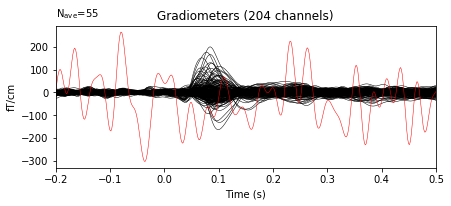

In [15]:
# Reading data with a bad channel marked as bad:
fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
evoked = mne.read_evokeds(fname, condition='Left Auditory',
                          baseline=(None, 0))
evoked.pick_types(meg='grad', eeg=False, exclude=[])

# plot with bads
evoked.plot(exclude=[], time_unit='s');

It's also possible to repair the bad channels using interpolation

In [16]:
evoked.interpolate_bads(reset_bads=False, verbose=False);

Let’s plot the cleaned data

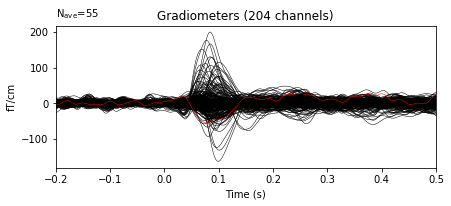

In [17]:
evoked.plot(exclude=[], time_unit='s');

Marking bad epochs
--------------------

MNE allows you to specify rejection dictionary based on peak-to-peak thresholds for each channel type

In [19]:
reject = dict(grad=4000e-13, mag=4e-12, eog=200e-6)

In [20]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)
raw.set_eeg_reference()

events = mne.find_events(raw, stim_channel='STI 014')
event_id = {"auditory/left": 1}
tmin, tmax = -0.2, 0.5
baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(raw.info, meg=True, eeg=True, eog=True,
                       stim=False, exclude='bads')
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=reject,                    
                    preload=True)

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
Applying average reference.
Applying a custom EEG reference.
Created an SSP operator (subspace dimension = 3)
320 events found
Event IDs: [ 1  2  3  4  5 32]
72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Loading data for 72 events and 421 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on MAG : ['MEG 1711

You can also reject after constructing epochs, just do:

In [23]:
reject.update({'eog': 149e-6})
epochs.drop_bad(reject=reject)

0 bad epochs dropped


<Epochs  |   55 events (all good), -0.199795 - 0.499488 sec, baseline [None, 0], ~68.1 MB, data loaded,
 'auditory/left': 55>

But the thresholds need to be stricter each time.

Tuning rejection thresholds
---------------------------

In [27]:
import matplotlib.pyplot as plt
from ipywidgets import interact

picks = mne.pick_types(raw.info, meg=False, eeg=True)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                    
                    preload=True)

def reject_epochs(reject):
    reject = dict(eeg=reject * 1e-6)
    evoked = epochs.copy().drop_bad(reject=reject, verbose=False).average()
    evoked.plot(spatial_colors=True)
    print('Number of epochs retained: %d/%d' % (evoked.nave, len(epochs)))

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
3 projection items activated
Loading data for 72 events and 421 original time points ...
0 bad epochs dropped


In [26]:
interact(reject_epochs, reject=(55, 250, 10));

interactive(children=(IntSlider(value=145, description='reject', max=250, min=55, step=10), Output()), _dom_cl…

Autoreject
----------

In [72]:
# !pip install -U https://api.github.com/repos/autoreject/autoreject/zipball/master

We need to make a release soon ... (the stable version doesn't work with latest MNE because MNE moved to Python 3)

Autoreject (global) can compute the rejection dictionary automatically

In [21]:
from autoreject import get_rejection_threshold  # noqa
reject = get_rejection_threshold(epochs)
print(reject)

Estimating rejection dictionary for eeg
{'eeg': 0.00011796905867925756}


Autoreject (local) finds per channel thresholds:

![](http://autoreject.github.io/_images/sphx_glr_plot_visualize_bad_epochs_002.png)

In [28]:
import numpy as np
from autoreject import AutoReject

n_interpolates = np.array([1, 2, 4])
consensus = np.linspace(0.5, 1.0, 6)

ar = AutoReject(n_interpolates, consensus, thresh_method='random_search',
                random_state=42)

Now, we find the rejection thresholds per-channel and optimize for the number of channels to be interpolated.

In [29]:
raw.info['bads'] = []
picks = mne.pick_types(raw.info, meg='grad', eeg=False)
epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True,
                    picks=picks, baseline=baseline, reject=None,                    
                    preload=True)

# Note that fitting and transforming can be done on different compatible
# portions of data if needed.
ar.fit(epochs['auditory/left'])

72 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
3 projection items activated
Loading data for 72 events and 421 original time points ...
0 bad epochs dropped
84 coil definitions read
Running autoreject on ch_type=grad

[........................................] 100.00% Creating augmented epochs | 
[........................................] 100.00% Computing thresholds ... |  
[........................................] 100.00% Repairing epochs |   
[                                        ]   0.00% n_interp |   
[........................................] 100.00% Repairing epochs |   
[.............                           ]  33.33% n_interp /   
[........................................] 100.00% Repairing epochs |   
[..........................              ]  66.67% n_interp -   
[........................................] 100.00% Repairing epochs |   
[........................................] 100.00% n_interp \   



Estimated consensus=0.50 a

AutoReject(consensus=array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), cv=10,
      n_interpolate=array([1, 2, 4]), n_jobs=1, picks=None,
      random_state=42, thresh_method='random_search',
      verbose='progressbar')

Now, we can look at the rejection thresholds for each channel

In [30]:
for ch_name in epochs.info['ch_names'][:5]:
     print('%s: %s' % (ch_name, ar.threshes_[ch_name]))

# plt.hist(np.array(list(ar.threshes_.values())), 30, color='g', alpha=0.4)

MEG 0113: 5.639544098423444e-11
MEG 0112: 4.6635154431498864e-11
MEG 0122: 5.0339646058266195e-11
MEG 0123: 5.1590182028633666e-11
MEG 0132: 8.526141573813761e-11


We can check what applying autoreject would do to the epochs:
    
* Good data (light red)
* Bad segment but not to be interpolated (medium dark red)
* Bad segment to be interpolated (dark red)

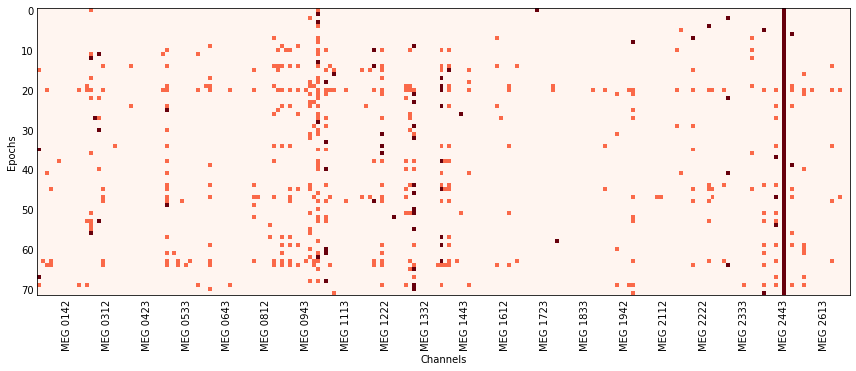

In [31]:
reject_log = ar.get_reject_log(epochs['auditory/left'])
reject_log.plot()

Another way to visualize this is to plot them on the epochs

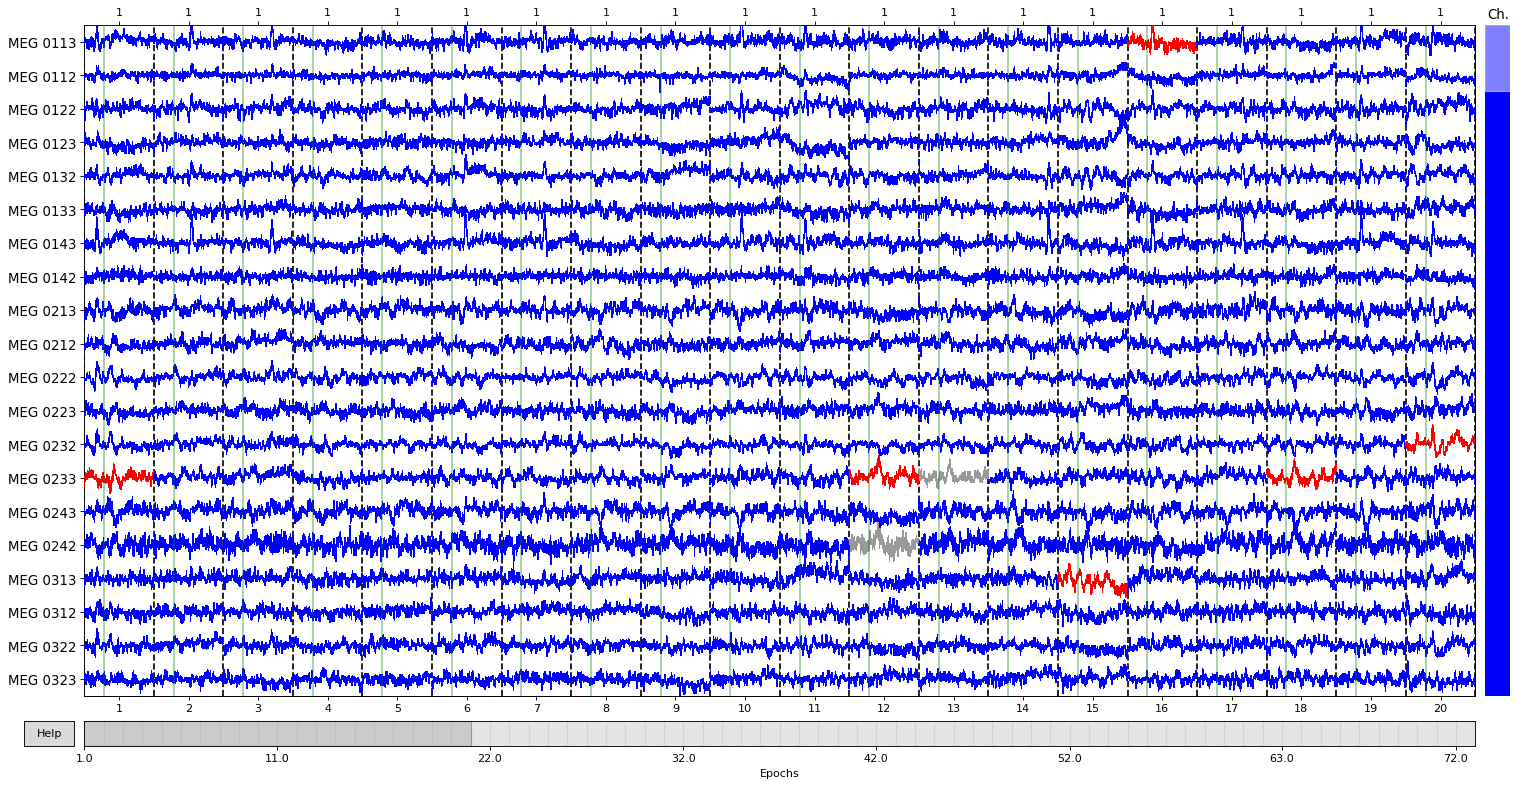

In [32]:
reject_log.plot_epochs(epochs['auditory/left']);

We can apply these rejection thresholds to new (or to the old) data:

In [34]:
epochs_clean = ar.transform(epochs['auditory/left'])


[........................................] 100.00% Repairing epochs |   

/home/mainak/Desktop/projects/github_repos/autoreject/autoreject/autoreject.py:1142: UserWarning: No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.
  "No bad epochs were found for your data. Returning "


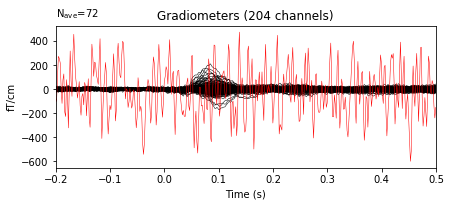

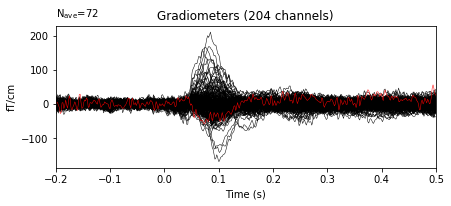

In [35]:
evoked = epochs['auditory/left'].average()
evoked.info['bads'] = ['MEG 2443']
evoked.plot(exclude=[]);

evoked_clean = epochs_clean.average()
evoked_clean.info['bads'] = ['MEG 2443']
evoked_clean.plot(exclude=[]);

For more info, visit

[http://autoreject.github.io/](http://autoreject.github.io/)

# Signal Space Projection (SSP)

We can write the measured signal $b \in \mathbb{R}^{C \times T}$ as

$$ b = b_s + b_n$$

where $b_s\in \mathbb{R}^{C \times T}$ is the brain signals and $b_n(t) \in \mathbb{R}^{C \times T}$ is the noise

Noise $b_n$ can be:
* ambient sensor noise
* electrophysiological corruption
 * cardiac
 * ocular

Now, we can apply PCA on $b_n$ and keep only top $M$ components with loadings $ c_n \in \mathbb{R}^M$:
    
$$ b_n = Uc_n + e_n$$

where $U = [b_1, ..., b_M] \in \mathbb{R}^{C \times M}$ are the orthonormal basis.

Now, the SSP operator $P_{\perp} \in \mathbb{R}^{C \times C}$ is given by:

$$ P_{\perp} = I - UU{^\top} $$

so that:

$$b_s \approx P_{\perp}b$$


Artifact Correction with SSP
============================

This tutorial explains how to estimate Signal Subspace Projectors (SSP)
for correction of ECG and EOG artifacts.

In [1]:
%matplotlib qt

import mne
from mne.preprocessing import compute_proj_ecg, compute_proj_eog

from mne.datasets import sample

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


We can see that the raw data has projectors computed but not yet applied.

In [2]:
print(raw.info['projs'])

[<Projection  |  PCA-v1, active : False, n_channels : 102>, <Projection  |  PCA-v2, active : False, n_channels : 102>, <Projection  |  PCA-v3, active : False, n_channels : 102>]


Exercise
------------

Where did these projectors come from? What was the noise $b_n$?

To interactively explore the effect of applying proj, use `raw.plot()` and click on the "proj" button

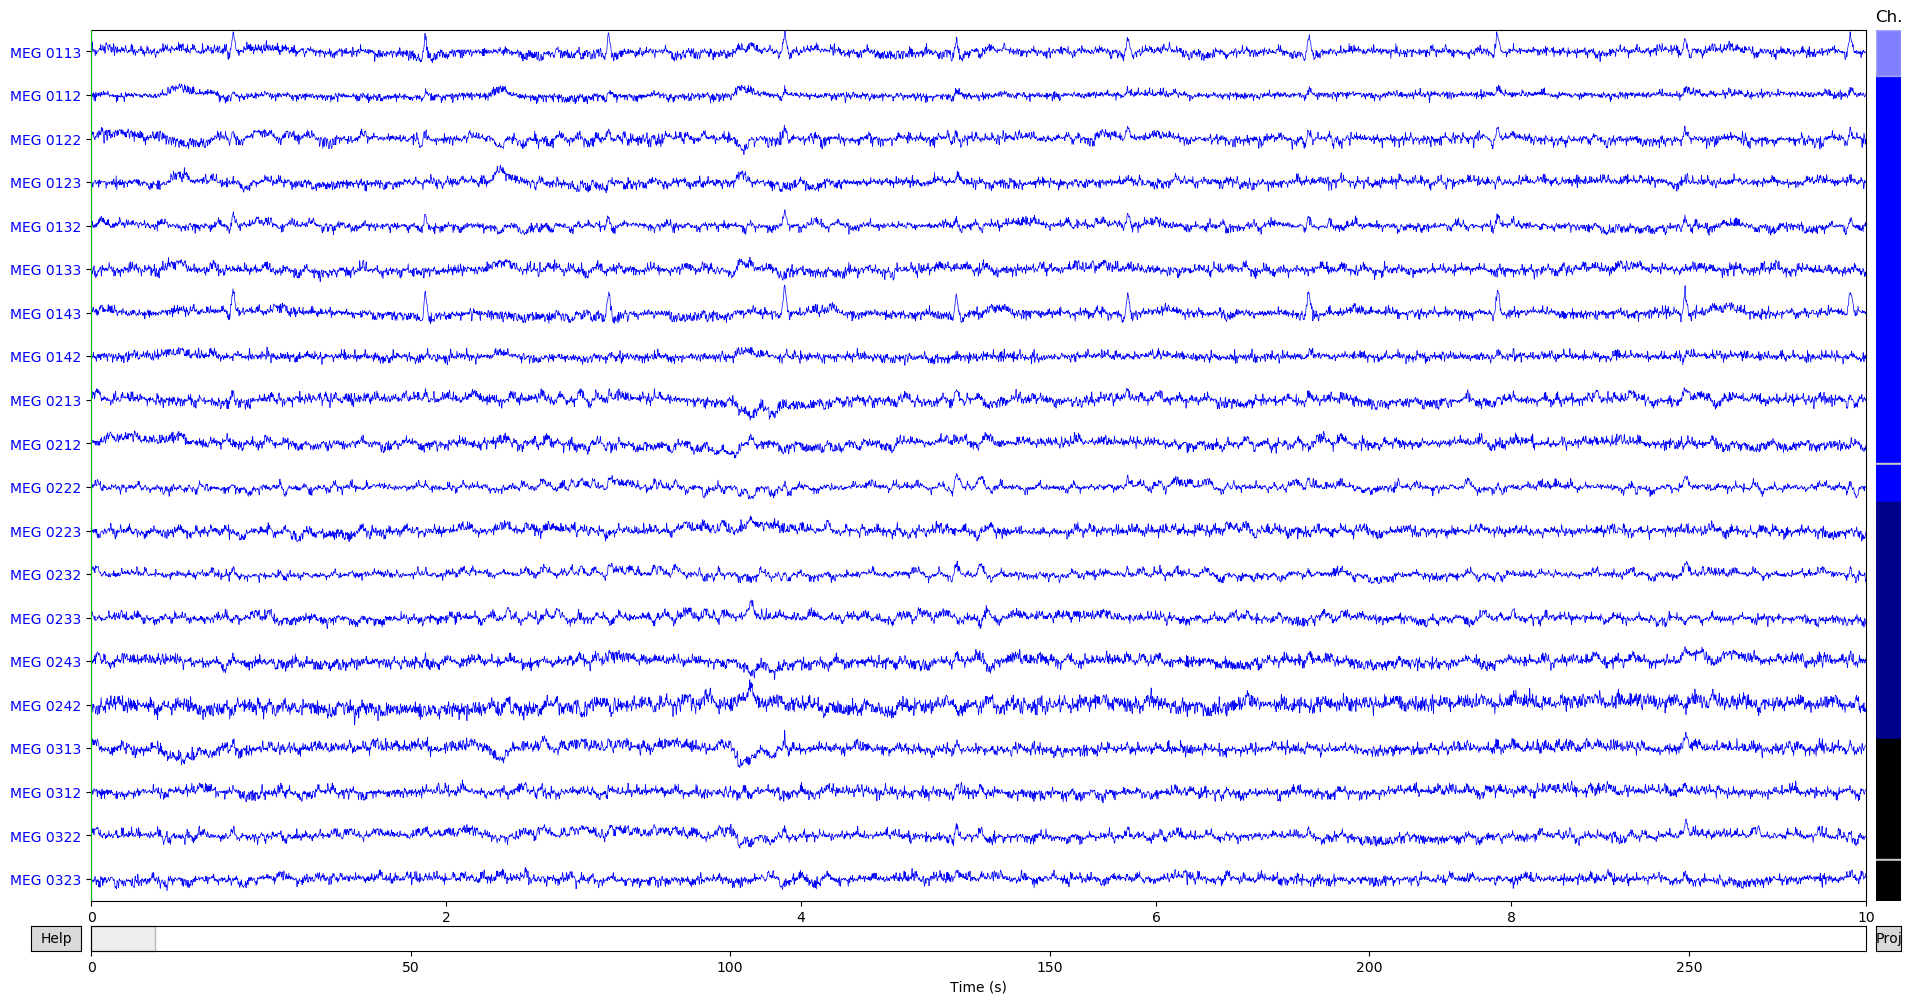

In [3]:
raw.plot()

Now, we can apply the projectors by doing:

In [4]:
raw.apply_proj()
print(raw.info['projs'])

Created an SSP operator (subspace dimension = 3)
3 projection items activated
SSP projectors applied...
[<Projection  |  PCA-v1, active : True, n_channels : 102>, <Projection  |  PCA-v2, active : True, n_channels : 102>, <Projection  |  PCA-v3, active : True, n_channels : 102>]


Compute SSP projections
-----------------------

First let's do ECG.



In [5]:
projs, events = compute_proj_ecg(raw, n_grad=1, n_mag=1, n_eeg=0, average=True, verbose=False)

ecg_projs = projs[-2:]
mne.viz.plot_projs_topomap(ecg_projs);

Now let's do EOG. Here we compute an EEG projector, and need to pass
the measurement info so the topomap coordinates can be created.



In [6]:
projs, events = compute_proj_eog(raw, n_grad=1, n_mag=1, n_eeg=1, average=True, verbose=False)
print(projs)

eog_projs = projs[-3:]
mne.viz.plot_projs_topomap(eog_projs, info=raw.info);

[<Projection  |  PCA-v1, active : True, n_channels : 102>, <Projection  |  PCA-v2, active : True, n_channels : 102>, <Projection  |  PCA-v3, active : True, n_channels : 102>, <Projection  |  EOG-planar--0.200-0.200-PCA-01, active : False, n_channels : 203>, <Projection  |  EOG-axial--0.200-0.200-PCA-01, active : False, n_channels : 102>, <Projection  |  EOG-eeg--0.200-0.200-PCA-01, active : False, n_channels : 59>]


Exercise
-------------
What are we plotting here? Is it the SSP operator?

Add SSP projections
---------------------

MNE is handling projections at the level of the info,
so to register them populate the list that you find in the 'proj' field



In [9]:
raw.info['projs'] += eog_projs + ecg_projs
# raw.add_proj
raw.info['projs']

[<Projection  |  PCA-v1, active : True, n_channels : 102>,
 <Projection  |  PCA-v2, active : True, n_channels : 102>,
 <Projection  |  PCA-v3, active : True, n_channels : 102>,
 <Projection  |  EOG-planar--0.200-0.200-PCA-01, active : False, n_channels : 203>,
 <Projection  |  EOG-axial--0.200-0.200-PCA-01, active : False, n_channels : 102>,
 <Projection  |  EOG-eeg--0.200-0.200-PCA-01, active : False, n_channels : 59>,
 <Projection  |  ECG-planar--0.200-0.400-PCA-01, active : False, n_channels : 203>,
 <Projection  |  ECG-axial--0.200-0.400-PCA-01, active : False, n_channels : 102>]

Now MNE will apply the projs on demand at any later stage,
so watch out for proj parmeters in functions or to it explicitly
with the ``.apply_proj`` method



Demonstrate SSP cleaning on some evoked data
--------------------------------------------



In [10]:
events = mne.find_events(raw, stim_channel='STI 014')
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
# this can be highly data dependent
event_id = {'auditory/right': 2}

epochs_no_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                            proj=False, baseline=(None, 0), reject=reject,
                            verbose=False)
epochs_no_proj.average().plot(spatial_colors=True, time_unit='s');


epochs_proj = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, proj=True,
                         baseline=(None, 0), reject=reject, verbose=False)
epochs_proj.average().plot(spatial_colors=True, time_unit='s');

320 events found
Event IDs: [ 1  2  3  4  5 32]


Interactive topomaps with SSP applied

In [12]:
import numpy as np

raw = mne.io.read_raw_fif(raw_fname, preload=True)
evoked = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                    proj='delayed', baseline=(None, 0),
                    reject=reject, verbose=False).average()

# set time instants in seconds (from 50 to 150ms in a step of 10ms)
times = np.arange(0.05, 0.15, 0.01)

fig = evoked.plot_topomap(times, proj='interactive', time_unit='s')

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...
SSP projectors applied...
SSP projectors applied...
SSP projectors applied...
SSP projectors applied...
SSP projectors applied...
SSP projectors applied...


Now you should see checkboxes. Remove a few SSP and see how the auditory
pattern suddenly drops off



Exercises
---------

1) Can you compute your own proj using empty room data?

In [51]:
erm_fname = data_path + 'sample/MEG/ernoise_raw.fif'
mne.compute_proj_raw?

2) How would you compute the SSP from the evoked baseline instead of empty room?

Adding projection: axial--0.200-0.000-PCA-01
Adding projection: axial--0.200-0.000-PCA-02


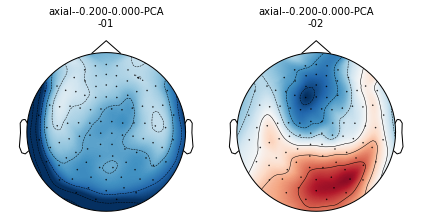

In [52]:
raw = mne.io.read_raw_fif(raw_fname, preload=True, verbose=False)
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)
evoked = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5,
                    proj='delayed', baseline=(None, 0),
                    reject=reject, verbose=False).average()

projs = mne.compute_proj_evoked(evoked.copy().crop(tmax=0), n_grad=0, n_mag=2, n_eeg=0)
mne.viz.plot_projs_topomap(projs, info=evoked.info);

Try making `reject=None`. What happens? Why?

# ICA

We want to decompose our data $X \in \mathbb{R}^{C \times T}$

$$ X = As $$ 

where $A \in \mathbb{R}^{C \times C}$ is the mixing matrix and $s \in \mathbb{R}^{C \times T}$ are the (independant) latent sources

Each row of $s$ is a statistically independent time series and each column of $A$ is a spatial filter

ICA finds directions in the feature space
corresponding to projections with high non-Gaussianity. We thus obtain
a decomposition into independent components, and the artifact's contribution
is typically localized in only a small number of components.
These components have to be correctly identified and removed.

If EOG or ECG recordings are available, they can be used in ICA to
automatically select the corresponding artifact components from the
decomposition. To do so, you have to first build an `mne.Epochs` object
around blink or heartbeat events.

ICA is implemented in MNE using the `mne.preprocessing.ICA` class,
which we will review here.



First, let us load the data and filter it

In [13]:
raw = mne.io.read_raw_fif(raw_fname, preload=True)

Opening raw data file /home/mainak/Desktop/projects/github_repos/mne-python/examples/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


1Hz high pass is often helpful for fitting ICA (already lowpassed @ 40 Hz)

In [14]:
raw.filter(1., None, n_jobs=1, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1983 samples (3.302 sec)



<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 166800 (277.7 sec), ~482.1 MB, data loaded>

The three line summary
----------------------

In [15]:
from mne.preprocessing import ICA

raw.plot();
ica = ICA(n_components=25, method='fastica', random_state=23).fit(raw)
ica.exclude = [1]
raw_clean = ica.apply(raw.copy())

Fitting ICA to data using 364 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by number: 25 components
Fitting ICA took 20.2s.
Transforming to ICA space (25 components)
Zeroing out 1 ICA components


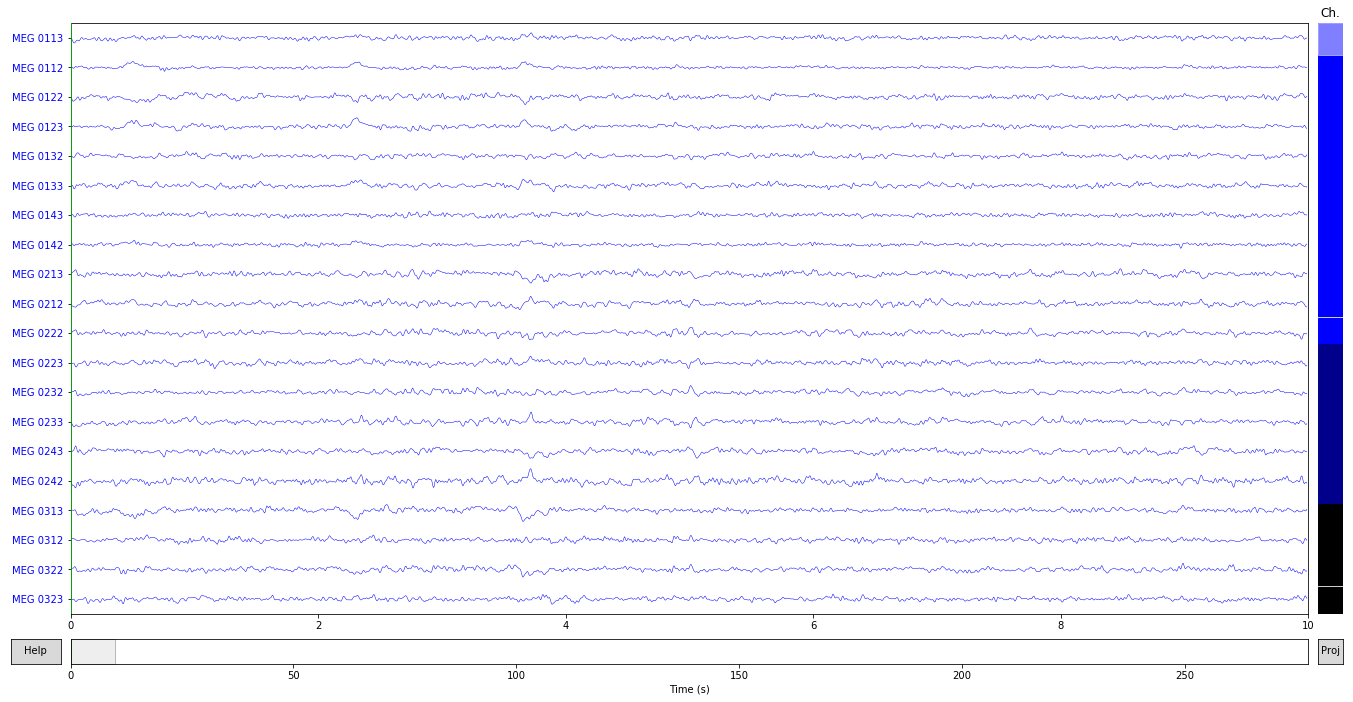

In [56]:
raw_clean.plot();

Fit ICA
-------

First, choose the ICA method. There are currently four possible choices:
`fastica`, `picard`, `infomax` and `extended-infomax`.

In [16]:
method = 'fastica'

# Choose other parameters
n_components = 25  # if float, select n_components by explained variance of PCA
decim = 3  # we need sufficient statistics, not all time points -> saves time

ICA is a non-deterministic algorithm, but we want to have the same decomposition
and the same order of components

In [17]:
random_state = 23

Define the ICA object instance



In [18]:
ica = ICA(n_components=n_components, method=method, random_state=random_state)
print(ica)

<ICA  |  no decomposition, fit (fastica):  samples, no dimension reduction>


We avoid fitting ICA on crazy environmental artifacts that would
dominate the variance and decomposition



In [19]:
reject = dict(mag=5e-12, grad=4000e-13)

picks_meg = mne.pick_types(raw.info, meg=True, eeg=False, eog=False,
                           stim=False, exclude='bads')
ica.fit(raw, picks=picks_meg, decim=decim, reject=reject)
print(ica)

Fitting ICA to data using 305 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [16842, 17243]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [23258, 23659]
    Rejecting  epoch based on MAG : ['MEG 0131']
Artifact detected in [49323, 49724]
Selection by number: 25 components
Fitting ICA took 7.5s.
<ICA  |  raw data decomposition, fit (fastica): 54135 samples, 25 components, channels used: "mag"; "grad">


Plot ICA components



In [20]:
ica.plot_components();  # can you spot some potential bad guys?

In [21]:
ica.plot_sources(raw);

Component properties
--------------------

Let's take a closer look at properties of first three independent components.



    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [12642, 12943]
    Rejecting  epoch based on MAG : ['MEG 1711']
Artifact detected in [17458, 17759]
Creating RawArray with float64 data, n_channels=376, n_times=40936
Current compensation grade : 0
    Range : 0 ... 40935 =      0.000 ...   272.621 secs
Ready.
    Using multitaper spectrum estimation with 7 DPSS windows


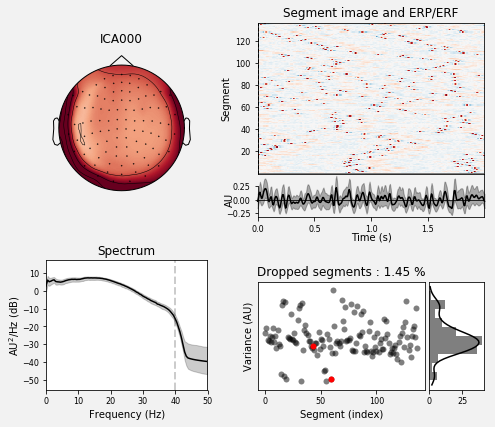

[<Figure size 504x432 with 6 Axes>]

In [63]:
# first, component 0:
ica.plot_properties(raw, picks=0)

Advanced artifact detection
---------------------------

Let's use a more efficient way to find artifacts



In [22]:
from mne.preprocessing import create_eog_epochs

eog_average = create_eog_epochs(raw, reject=dict(mag=5e-12, grad=4000e-13),
                                picks=picks_meg).average()

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 8192 samples (13.639 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition 

In [23]:
eog_epochs = create_eog_epochs(raw, reject=reject)  # get single EOG trials
eog_inds, scores = ica.find_bads_eog(eog_epochs)  # find via correlation

ica.plot_scores(scores, exclude=eog_inds);  # look at r scores of components

EOG channel index for this subject is: [375]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 8192 samples (13.639 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition 

we can see that only one component is highly correlated and that this
component got detected by our correlation analysis (red).

In [24]:
ica.plot_sources(eog_average, exclude=eog_inds);  # look at source time course

We can take a look at the properties of that component, now using the
data epoched with respect to EOG events.
We will also use a little bit of smoothing along the trials axis in the
epochs image:



    Using multitaper spectrum estimation with 7 DPSS windows


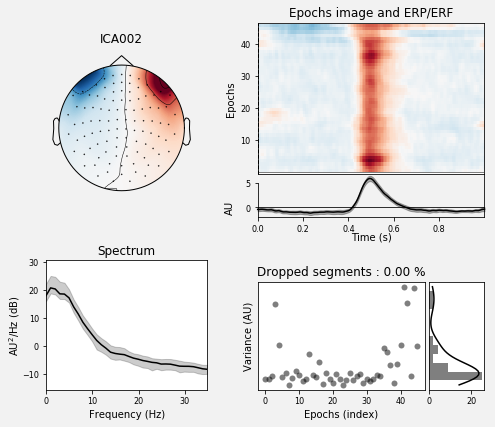

[<Figure size 504x432 with 6 Axes>]

In [67]:
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.})

Now let's see how we would modify our signals if we removed this component
from the data.


Transforming to ICA space (25 components)
Zeroing out 1 ICA components


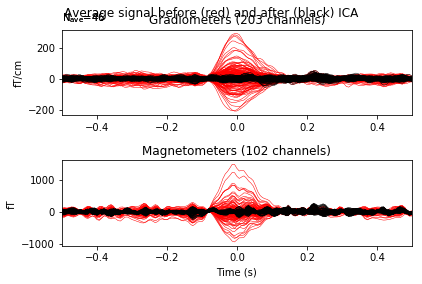

In [68]:
ica.plot_overlay(eog_average, exclude=eog_inds, show=False)
# red -> before, black -> after. Yes! We remove quite a lot!

# to definitely register this component as a bad one to be removed
# there is the ``ica.exclude`` attribute, a simple Python list
ica.exclude.extend(eog_inds)

from now on the ICA will reject this component even if no exclude
parameter is passed, and this information will be stored to disk
on saving

In [69]:
# uncomment this for reading and writing
# ica.save('my-ica.fif')
# ica = read_ica('my-ica.fif')

Note that nothing is yet removed from the raw data. To remove the effects of
the rejected components, `mne.preprocessing.ICA.apply` must be called.
Here we apply it on the copy of the first ten seconds, so that the rest of
this tutorial still works as intended.

Transforming to ICA space (25 components)
Zeroing out 1 ICA components


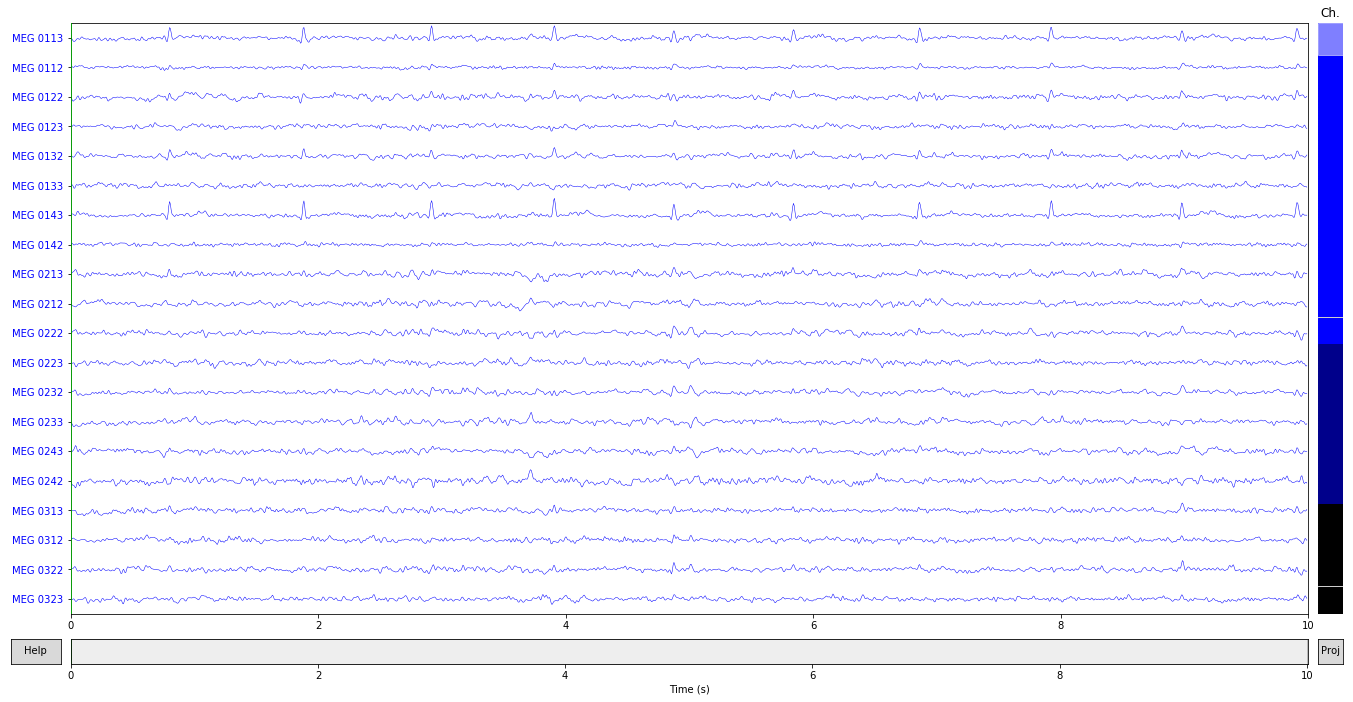

In [70]:
raw_copy = raw.copy().crop(0, 10)
ica.apply(raw_copy)
raw_copy.plot();  # check the result

Exercise
-------------

Find and remove ECG artifacts using ICA!



In [71]:
from mne.preprocessing import create_ecg_epochs